# PIDI (III): Toy Problem
Author: Addison Howe

## Toy Problem: 1-D Potential

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split

from jax import config
config.update("jax_enable_x64", True)
# config.update('jax_log_compiles', True)

import jax
import jax.numpy as jnp
import jax.random as jrandom
from jaxtyping import Float, Array, PyTree

from diffrax import diffeqsolve, PIDController, ConstantStepSize, SaveAt
from diffrax import ODETerm, Euler, Dopri5, Dopri8, Kvaerno4
import equinox as eqx
import optax

from helpers import CustomDataset, NumpyLoader

In [2]:
seed = 12345
rng = np.random.default_rng(seed=seed)  # numpy random number generator
key = jrandom.PRNGKey(seed=rng.integers(2**32))  # jax random number generator
torch.manual_seed(int(rng.integers(2**32)));

Begin by constructing a potential function $\phi(x)$, which is our unknown underlying landscape.

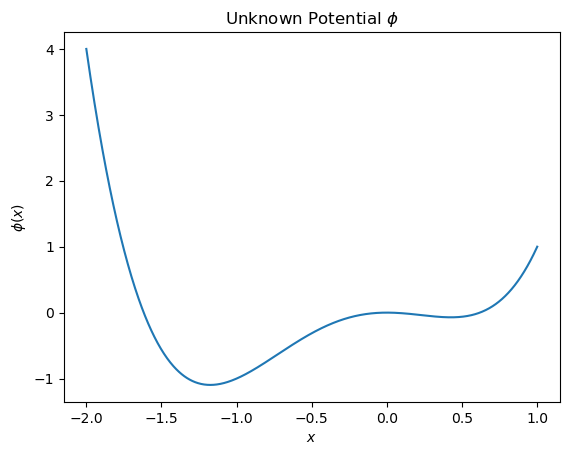

In [3]:
def phi(x):
    return x**4 + x**3 - x**2

xs = np.linspace(-2, 1, 1000)
plt.plot(xs, phi(xs))
plt.xlabel("$x$");
plt.ylabel("$\phi(x)$");
plt.title("Unknown Potential $\phi$");

In [4]:
def get_field(phi):
    def f(x):
        return -jax.grad(phi)(x)
    return f


def simulate_trajectory(
        f, t0, x0, t1, saveat,
        solver=Euler(),
        dt0=0.001, 
        stepsize_controller=ConstantStepSize(),
):
    def rhs(t, y, args):
        return f(y)
    
    res = diffeqsolve(
        ODETerm(rhs),
        solver=solver,
        saveat=saveat,
        t0=t0, 
        t1=t1, 
        dt0=dt0,
        y0=x0,
        stepsize_controller=stepsize_controller,
    )
    return res.ts, res.ys


def simulate_ensemble(
        potential, tfin, dt, x0s, 
        solver=Euler(),
        dt0=0.001,
        stepsize_controller=ConstantStepSize(),
):
    # Make the vector field from the potential
    f = get_field(potential)

    # Use jax.vmap to simulate an ensemble of trajectories
    saveat = SaveAt(ts = jnp.linspace(0, tfin, int(1+tfin/dt)))
    def sim_traj(x0):
        return simulate_trajectory(
            f, 0., x0, tfin, saveat, 
            solver=solver,
            dt0=dt0,
            stepsize_controller=stepsize_controller,
        )
    
    sim_ens = jax.vmap(sim_traj, 0)
    ts_trajs, xs_trajs = sim_ens(x0s)
    return ts_trajs, xs_trajs

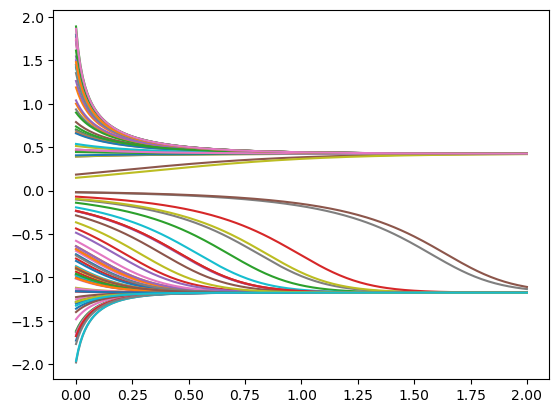

In [5]:
ntrajs = 100
x0_range = [-2, 2]
x0s = rng.uniform(x0_range[0], x0_range[1], size=ntrajs)

ts, xs = simulate_ensemble(
    phi, 2., 0.01, x0s, 
    solver=Dopri8(), dt0=0.01, 
    stepsize_controller=PIDController(atol=1e-5, rtol=1e-5)
)

plt.plot(ts.T, xs.T);

### Prepare training and validation data

In [6]:
ntrajs = 1000
x0_range = [-2, 1.5]
x0s = rng.uniform(x0_range[0], x0_range[1], size=ntrajs)

data_ts, data_xs = simulate_ensemble(
    phi, 2., 0.1, x0s, 
    solver=Dopri8(), dt0=0.001, 
    stepsize_controller=PIDController(atol=1e-5, rtol=1e-5)
)

print(data_ts.shape)
print(data_xs.shape)

(1000, 21)
(1000, 21)


Convert the data to the form $\left\{(t_0, x_0, t_1, t(\cdot), x(\cdot))\right\}_i$

In [7]:
data = []
for i in range(len(data_ts)):
    ts = data_ts[i]
    xs = data_xs[i]
    data.append(
        [ts[0].item(), xs[0].item(), ts[-1].item(), np.array(ts), np.array(xs)]
    )

print(data[0])

[0.0, -1.1594957955940925, 2.0, array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), array([-1.1594958 , -1.16780837, -1.17179888, -1.17369294, -1.17459464,
       -1.1750145 , -1.17521301, -1.17530761, -1.17535127, -1.17537197,
       -1.1753818 , -1.1753866 , -1.17538899, -1.17538971, -1.17539018,
       -1.17539039, -1.17539038, -1.17539057, -1.17539064, -1.17539058,
       -1.17539055])]


In [8]:
dataset = CustomDataset(data)

In [9]:
class Model(eqx.Module):

    phi_mlp: eqx.Module

    def __init__(self, key):
        key, subkey = jrandom.split(key, 2)
        self.phi_mlp = eqx.nn.MLP(
            key=subkey,
            in_size="scalar", 
            out_size="scalar",
            width_size=32,
            depth=8,
            activation=jax.nn.softplus,
            # final_activation=jax.nn.softplus,  # default Identity
            use_final_bias=False,
        )

    def __call__(
            self, t0, x0, t1, ts,
            solver=Euler(),
            dt0=0.001,
            stepsize_controller=ConstantStepSize(),
    ):
        return self.simulate_trajectory(
            t0, x0, t1, ts, solver, dt0, stepsize_controller
        )[0]
    
    def phi(self, x):
        return 0.1*x*x + self.phi_mlp(x)
    
    def f(self, t, y, args):
        return -jax.grad(self.phi)(y)
    
    def simulate_trajectory(
            self, t0, x0, t1, ts, 
            solver=Euler(),
            dt0=0.001, 
            stepsize_controller=ConstantStepSize()
    ):
        saveat = SaveAt(ts=ts)
        
        res = diffeqsolve(
            ODETerm(self.f),
            solver=solver,
            t0=t0, 
            t1=t1, 
            dt0=dt0,
            y0=x0,
            saveat=saveat,
            stepsize_controller=stepsize_controller,
        )
        return res.ys, res
    
    def simulate_ensemble(
            self, t0s, x0s, t1s, tss,
            solver=Euler(),
            dt0=0.001, 
            stepsize_controller=ConstantStepSize(),
    ):
        def sim_traj(t0, x0, t1, ts):
            return self.simulate_trajectory(
                x0, t0, t1, ts, 
                solver=solver, dt0=dt0, 
                stepsize_controller=stepsize_controller,
            )[0]
        vfunc = jax.vmap(sim_traj, 0)
        return vfunc(x0s, t0s, t1s, tss)
    
    def initialize(self, key, dtype):
        key, key_w, key_b = jrandom.split(key, 3)
        is_linear = lambda x: isinstance(x, eqx.nn.Linear)

        # Initialize weights
        get_weights = lambda m: [
                x.weight for x in jax.tree_util.tree_leaves(
                    m, is_leaf=is_linear
                ) if is_linear(x)
            ]
        
        init_fn = jax.nn.initializers.glorot_uniform()
        weights = get_weights(self.phi)
        old_shapes = [None if w is None else w.shape for w in weights]
        new_weights = [
            init_fn(subkey, w.shape, dtype) for w, subkey 
            in zip(weights, jrandom.split(key_w, len(weights)))
        ]
        new_shapes = [None if w is None else w.shape for w in new_weights]
        if old_shapes != new_shapes:
            msg = f"Weights changed shape during initialization."
            msg += f"\nOld:\n{old_shapes}\nNew:\n{new_shapes}"
            raise RuntimeError(msg)
        model = eqx.tree_at(get_weights, self, new_weights)
        return model

    
key, subkey1, subkey2 = jrandom.split(key, 3)
model = Model(subkey1)
model = model.initialize(subkey2, jnp.float64)

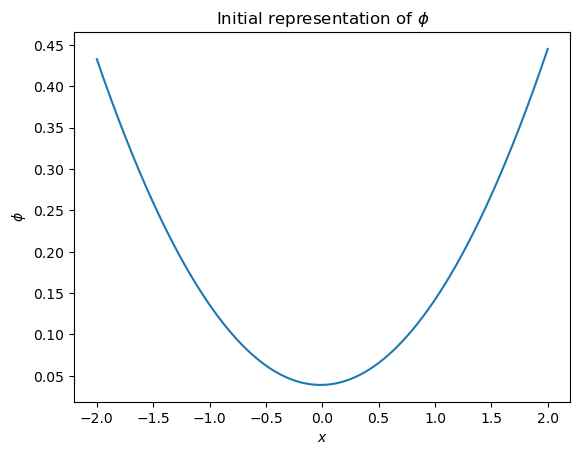

In [10]:
xs = jnp.linspace(-2, 2, 10000)
ys = jax.vmap(model.phi)(xs)

plt.plot(xs, ys)
plt.xlabel("$x$")
plt.ylabel("$\phi$")
plt.title("Initial representation of $\phi$");

### Training

In [11]:
@eqx.filter_jit
def loss(
        model: Model, 
        z: Float[Array, "5 batch"],
        solver=Euler(), 
        dt0=0.001, 
        stepsize_controller=ConstantStepSize(),
) -> Float[Array, ""]:
    
    # Unpack the input, z
    t0s, x0s, t1s, tss, xs = z
    
    # Wrap the model's forward call so it's easy to vectorize
    @eqx.filter_jit
    def call_model(t0, x0, t1, ts):
        return model(
            t0, x0, t1, ts, 
            solver=solver, 
            dt0=dt0, 
            stepsize_controller=stepsize_controller,
        )
    
    # Call the model across the batch dimension
    pred_x1s = jax.vmap(call_model, 0)(t0s, x0s, t1s, tss)
    
    # Compute the loss as a weighted sum of squared differences
    diffsq = jnp.square(xs - pred_x1s)
    loss = diffsq * jnp.exp(-tss)  # more weight for earlier times
    loss = jnp.sum(loss, -1)
    return jnp.mean(loss)


def evaluate(
        model: Model, 
        validloader: torch.utils.data.DataLoader,
        solver=Euler(), 
        dt0=0.001, 
        stepsize_controller=ConstantStepSize(),
):
    """Evaluate the model on the validation dataset."""
    avg_loss = 0.
    for z in validloader:
        avg_loss += loss(model, z, solver, dt0, stepsize_controller).item()
    return avg_loss / len(validloader)

In [12]:
def train_epochs(
    model: Model,
    trainloader: torch.utils.data.DataLoader,
    validloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    nepochs: int,
    solver=Euler(),
    dt0=0.001,
    stepsize_controller=ConstantStepSize(),
    ax_phi=None,
    ax_loss=None,
    train_loss_hist=[],
    valid_loss_hist=[],
    epochs_trained=0,
    starts=[],
    epoch_idxs=[],
    true_phi=None,
) -> (Model, Model, list, list):

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, 
    # updating the model -- into a single JIT region. This ensures things run 
    # as fast as possible.
    @eqx.filter_jit
    def make_step(
        model: Model,
        opt_state: PyTree,
        z: Float[Array, "batch 5"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, z, solver, dt0, stepsize_controller
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    best_model = model
    best_loss = evaluate(
        model, validloader, solver, dt0, stepsize_controller
    )
    print(f"[epoch {epochs_trained}]: valid_loss: {best_loss:.6g}")

    epoch_idxs.append(epochs_trained)
    starts.append(epochs_trained)
    train_loss_hist.append(np.nan)
    valid_loss_hist.append(best_loss)

    if ax_phi:
        ax_phi.clear()
        ax_phi.set_title("Model $\phi$")
        ax_phi.set_xlabel("$x$")
        ax_phi.set_ylabel("$\phi$")
        xs_plt = jnp.linspace(-2, 1, 100)
        if true_phi:
            ys_plt = true_phi(xs_plt)
            ys_plt = ys_plt - ys_plt.min()
            ax_phi.plot(xs_plt, ys_plt, '-k', label="true $\phi$")
        ys_plt = jax.vmap(model.phi)(xs_plt)
        ys_plt = ys_plt - ys_plt.min()
        phi_plot_best, = ax_phi.plot(
            xs_plt, ys_plt, '--r', label="best"
        )
        phi_plot, = ax_phi.plot(
            xs_plt, ys_plt, ':b', label="current"
        )
        ax_phi.legend()
        ax_phi.get_figure().canvas.draw()
    if ax_loss:
        ax_loss.set_title("Loss")
        ax_loss.set_xlabel("epoch")
        ax_loss.set_ylabel("log loss")
        tloss_plot, = ax_loss.plot(
            epoch_idxs, np.log10(train_loss_hist), 'k', alpha=0.3,
            label="training"
        )
        vloss_plot, = ax_loss.plot(
            epoch_idxs, np.log10(valid_loss_hist), 'g', alpha=0.9,
            label="validation"
        )
        ax_loss.axvline(epochs_trained, color='k', linestyle=':', alpha=0.5)
        ax_loss.legend(handles=[tloss_plot, vloss_plot])

    try:
        for epoch in range(epochs_trained, epochs_trained + nepochs):
            
            # Pass over training data in batches
            t0 = time.time()
            for step, z in enumerate(trainloader):
                model, opt_state, train_loss = make_step(model, opt_state, z)
            t1 = time.time()
            train_time = t1 - t0
            
            # Evaluate the model
            t0 = time.time()
            valid_loss = evaluate(
                model, validloader, solver, dt0, stepsize_controller
            )
            t1 = time.time()
            valid_time = t1 - t0
            
            epoch_idxs.append(epoch + 1)
            train_loss_hist.append(train_loss.item())
            valid_loss_hist.append(valid_loss)
            
            # Plotting
            if ax_phi:
                ys_plt = jax.vmap(model.phi)(xs_plt)
                ys_plt = ys_plt - ys_plt.min()
                phi_plot.set_ydata(ys_plt)
                ax_phi.get_figure().canvas.draw()
            if ax_loss:
                log_tloss = np.log10(train_loss_hist)
                log_vloss = np.log10(valid_loss_hist)
                tloss_plot.set_xdata(epoch_idxs)
                vloss_plot.set_xdata(epoch_idxs)
                tloss_plot.set_ydata(log_tloss)
                vloss_plot.set_ydata(log_vloss)
                ax_loss.set_xlim(-0.5, 1 + len(log_vloss))
                ax_loss.set_ylim(
                    min(np.nanmin(log_tloss), np.nanmin(log_vloss)) - 0.1, 
                    max(np.nanmax(log_tloss), np.nanmax(log_vloss)) + 0.1
                )

            msg = f"[epoch {epoch+1}]: train_loss={train_loss.item():.6g}, " + \
                    f"valid_loss={valid_loss:.6g}, " + \
                    f"train_time={train_time:.6g}, " + \
                    f"valid_time={valid_time:.6g}"
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_model = model
                msg += ", (model improved)"
                eqx.tree_serialise_leaves("model.eqx", model)
                if ax_phi:
                    phi_plot_best.set_ydata(ys_plt)
                    ax_phi.get_figure().canvas.draw()
                if ax_loss:
                    ax_loss.plot(epoch+1, np.log10(valid_loss), 'r.', alpha=0.5)
            print(msg)
        res = {
            'best_model': best_model,
            'vloss_hist': valid_loss_hist,
            'tloss_hist': train_loss_hist,
            'epochs_trained': epoch + 1,
            'epoch_idxs': epoch_idxs,
            'starts': starts,
        }
        return model, res
    except KeyboardInterrupt as e:
        print(f"Halting during epoch {epoch+1}.")
        res = {
            'best_model': best_model,
            'vloss_hist': valid_loss_hist,
            'tloss_hist': train_loss_hist,
            'epochs_trained': epoch,
            'epoch_idxs': epoch_idxs,
            'starts': starts,
        }
        return model, res

In [13]:
BATCH_SIZE = 500

dset_train, dset_valid = random_split(dataset, [0.8, 0.2])
trainloader = NumpyLoader(dset_train, batch_size=BATCH_SIZE, shuffle=True)
validloader = NumpyLoader(dset_valid, batch_size=BATCH_SIZE, shuffle=False)

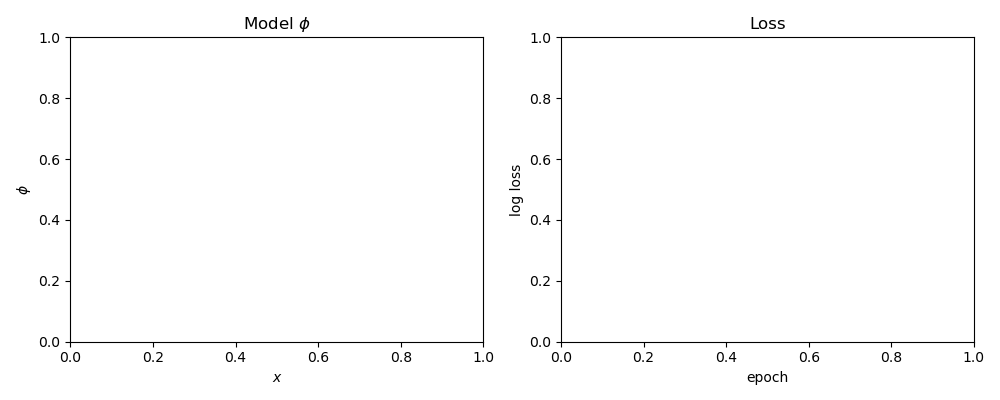

In [14]:
%matplotlib widget
fig, [wax1, wax2] = plt.subplots(1, 2, figsize=(10, 4))

wax1.set_title("Model $\phi$")
wax1.set_xlabel("$x$")
wax1.set_ylabel("$\phi$")

wax2.set_title("Loss")
wax2.set_xlabel("epoch")
wax2.set_ylabel("log loss")

plt.tight_layout()
plt.show()

In [15]:
epochs_trained = 0
starts = []
epochs = []
tloss_hist = []
vloss_hist = []

In [16]:
NEPOCHS = 200
LEARNING_RATE = 1e-2
SOLVER = Euler()
DT0 = 0.1
STEPSIZE_CONTROLLER = ConstantStepSize()

# NEPOCHS = 50
# LEARNING_RATE = 1e-3
# SOLVER = Dopri5()
# DT0 = 0.05
# STEPSIZE_CONTROLLER = PIDController(1e-4, 1e-6)

optim = optax.adamw(LEARNING_RATE)

model, res = train_epochs(
    model, trainloader, validloader, optim, 
    NEPOCHS, SOLVER, DT0, STEPSIZE_CONTROLLER, 
    train_loss_hist=tloss_hist,
    valid_loss_hist=vloss_hist,
    true_phi=phi,
    epochs_trained=epochs_trained,
    epoch_idxs=epochs,
    starts=starts,
    ax_phi=wax1, ax_loss=wax2,
)

best_model = res['best_model']
vloss_hist = res['vloss_hist']
tloss_hist = res['tloss_hist']
epochs_trained = res['epochs_trained']
epochs = res['epoch_idxs']
starts = res['starts']

model = best_model

[epoch 0]: valid_loss: 1.33987
[epoch 1]: train_loss=1.40672, valid_loss=1.04005, train_time=6.08554, valid_time=0.0260441, (model improved)
[epoch 2]: train_loss=1.59657, valid_loss=1.01579, train_time=0.31362, valid_time=0.0268109, (model improved)
[epoch 3]: train_loss=1.1835, valid_loss=1.12304, train_time=0.315665, valid_time=0.0271211
[epoch 4]: train_loss=1.36659, valid_loss=1.19078, train_time=0.314927, valid_time=0.0260177
[epoch 5]: train_loss=1.30123, valid_loss=1.18445, train_time=0.309344, valid_time=0.0258949
[epoch 6]: train_loss=1.23, valid_loss=1.12486, train_time=0.325744, valid_time=0.0257621
[epoch 7]: train_loss=1.15996, valid_loss=1.01175, train_time=0.311685, valid_time=0.0262887, (model improved)
[epoch 8]: train_loss=1.02847, valid_loss=1.05725, train_time=0.33156, valid_time=0.0268259
[epoch 9]: train_loss=1.08086, valid_loss=1.0743, train_time=0.322047, valid_time=0.0267181
[epoch 10]: train_loss=1.06566, valid_loss=0.966803, train_time=0.326463, valid_time=0

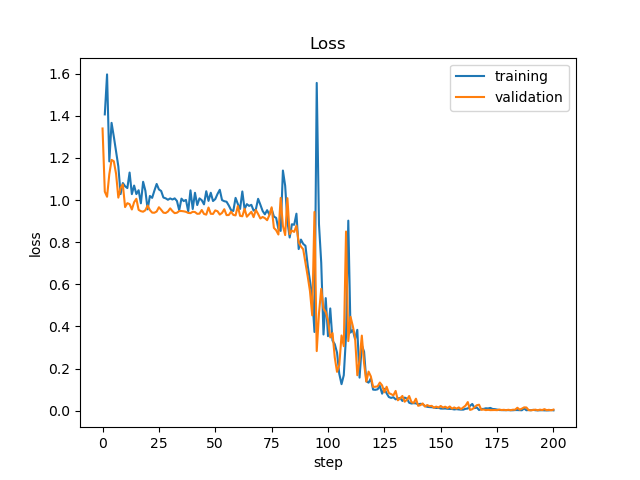

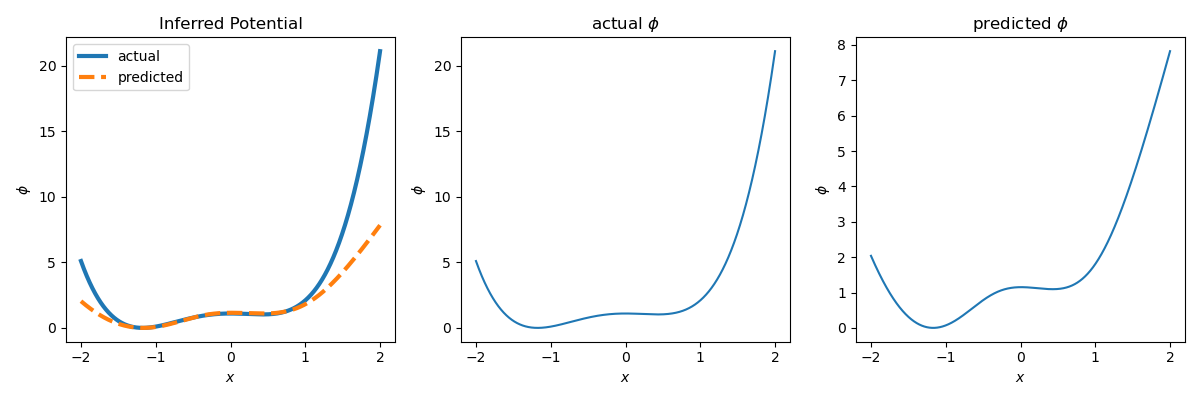

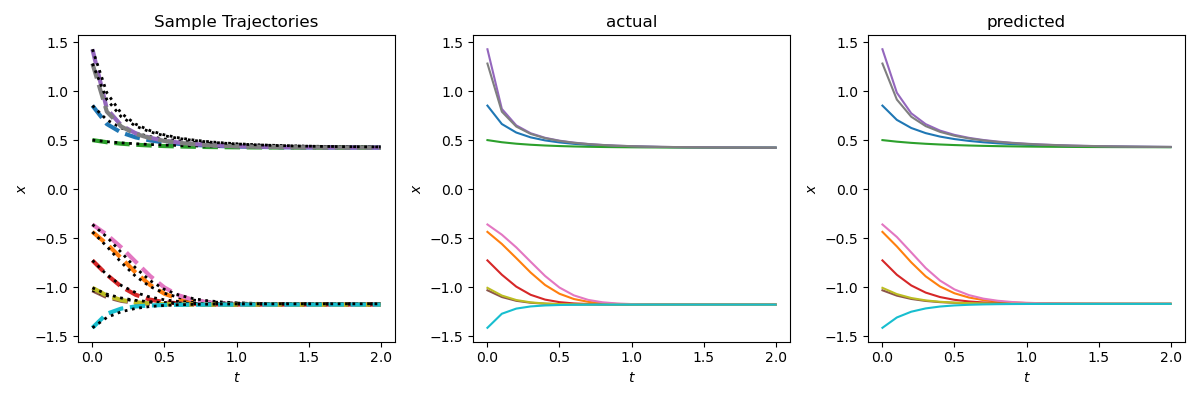

In [17]:
# Plot loss history
fig, ax = plt.subplots(1, 1)
ax.plot(tloss_hist, label="training")
ax.plot(vloss_hist, label="validation")
ax.set_xlabel("step")
ax.set_ylabel("loss")
ax.set_title("Loss")
ax.legend()


# Plot phi
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))

xs = jnp.linspace(-2, 2, 10000)
ys = jax.vmap(model.phi)(xs)
ys -= ys.min()
ys_true = phi(xs)
ys_true -= ys_true.min()

ax1.plot(xs, ys_true, '-', linewidth=3, label="actual")
ax1.plot(xs, ys, '--', linewidth=3, label="predicted")
ax1.legend()
ax2.plot(xs, ys_true)
ax3.plot(xs, ys)

ax1.set_title("Inferred Potential")
ax2.set_title("actual $\phi$")
ax3.set_title("predicted $\phi$")
ax1.set_xlabel("$x$")
ax2.set_xlabel("$x$")
ax3.set_xlabel("$x$")
ax1.set_ylabel("$\phi$")
ax2.set_ylabel("$\phi$")
ax3.set_ylabel("$\phi$")
plt.tight_layout()


# Plot trajectories
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))
k = 10
for i in range(k):
    t0, x0, t1, ts, xs = dset_valid[i]
    xs_sim = model.simulate_trajectory(
        0., x0, t1, ts, 
        Dopri8(), 0.01, PIDController(1e-5, 1e-5)
    )[0]
    
    line, = ax1.plot(ts, xs, '--', linewidth=3)
    ax1.plot(ts, xs_sim, 'k:', linewidth=2)

    ax2.plot(ts, xs)
    ax3.plot(ts, xs_sim)

ax1.set_title("Sample Trajectories")
ax2.set_title("actual")
ax3.set_title("predicted")
ax1.set_xlabel("$t$")
ax2.set_xlabel("$t$")
ax3.set_xlabel("$t$")
ax1.set_ylabel("$x$")
ax2.set_ylabel("$x$")
ax3.set_ylabel("$x$")
plt.tight_layout();